In [487]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from skimage.filters import frangi

In [488]:
import glob

IMAGES_NUMBER = 3
original_images = []

path = "./train-images/"

for i in range(1, IMAGES_NUMBER):
    filename_pattern = f"{path}{i:02d}_h.JPG"
    
    file_list = glob.glob(filename_pattern)
    original_images.append(file_list[0])

In [489]:
def load_image(path):
    image = io.imread(path)    
    return image

In [490]:
def process_image(train_image):
    original_image = load_image(train_image)
    kernel = np.ones((5, 5), np.uint8)

    image_green_channel = original_image[:, :, 1]
    thresh = cv2.dilate(image_green_channel, kernel, iterations=1)
    denoised_image = cv2.fastNlMeansDenoising(thresh, None, 10, 5, 21)
    sharp_image = exposure.equalize_hist(denoised_image)
    frangi_image = frangi(sharp_image, scale_step=2) 

    frangi_image[frangi_image > 0.0001] = 255
    frangi_image[frangi_image <= 0.0001] = 0

    threshold_value = 100
    ret, thresh = cv2.threshold(frangi_image, threshold_value, 255, cv2.THRESH_BINARY)
    return (frangi_image * cv2.erode(thresh, kernel)) / 255

In [491]:
trained_images = []

for train_image in original_images:
    trained_images.append(process_image(train_image))

In [492]:
def remove_background(mask, image):
    detected_vessels_image = []

    for i, row in enumerate(image):
        vessels = []
        for j in range(len(row)):
            if mask[i][j] < 100:
                vessels.append(0)
            else:
                vessels.append(image[i][j])

        detected_vessels_image.append(vessels)

    return detected_vessels_image

In [493]:
images_removed_background = []

path = "./fov-mask/"

for i in range(1, IMAGES_NUMBER):
    filename_pattern = f'{path}{i:02d}_h_mask.tif'
    mask = cv2.imread(filename_pattern, cv2.IMREAD_GRAYSCALE)
    images_removed_background.append(remove_background(mask, trained_images[i - 1]))

In [494]:
def save_all_images():
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 20))

    for idx, image in enumerate(images_removed_background):
        row_idx = idx // 2
        col_idx = idx % 2
        axes[row_idx, col_idx].imshow(image, cmap="gray")
        
    plt.tight_layout()
    plt.savefig('./res/preprocessed-images', dpi=1)

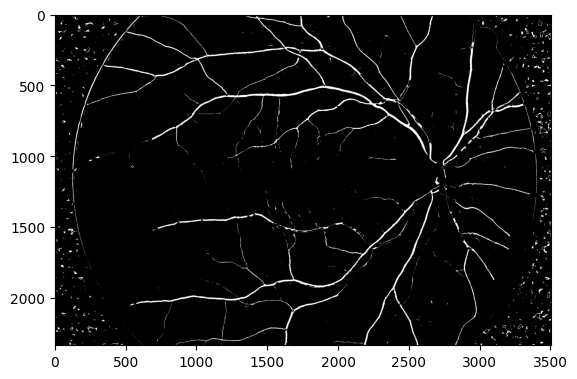

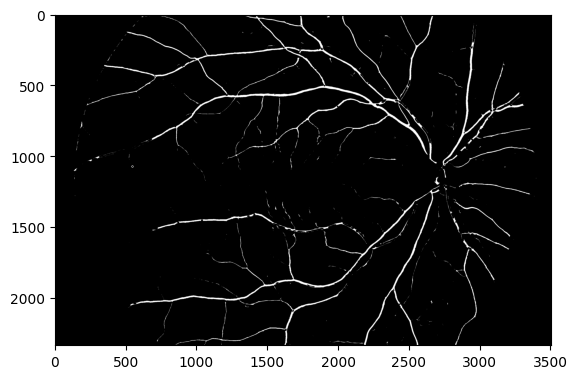

<Figure size 640x480 with 0 Axes>

In [495]:
plt.imshow(trained_images[0], cmap="gray")
plt.show()
plt.savefig('./res/sample-preprocessed-image-background', dpi=10)

plt.imshow(images_removed_background[0], cmap="gray")
plt.show()
plt.savefig('./res/sample-preprocessed-image', dpi=10)

In [496]:
vessel_mask_images = []
path = "./vessel_mask_images/"

for i in range(1, IMAGES_NUMBER):
    filename_pattern = f"{path}{i:02d}_h.tif"
    manually_labeled_image = cv2.imread(filename_pattern, cv2.IMREAD_GRAYSCALE)
    vessel_mask_images.append(manually_labeled_image)

In [497]:
from sklearn.metrics import confusion_matrix


def get_confusion_matrix_values(image):
    confusion_mat = confusion_matrix(image.flatten(), np.array(detected_vessels_image).flatten())
    true_negative, false_positive, false_negative, true_positive = confusion_mat.ravel()
    accuracy = (true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative)
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)

    print(confusion_mat)

In [498]:
def get_segments(image):
    parts_num = 5
    num_rows = image.shape[1] - parts_num
    num_cols = image.shape[0] - parts_num
    segments = []

    new_rows = image.shape[0] - (image.shape[0] % 5)
    new_cols = image.shape[1] - (image.shape[1] % 5)

    for i in range(0, new_rows,parts_num):
        for j in range(0, new_cols, parts_num):
            mat_5x5 = image[i: i + parts_num, j: j + parts_num]
            segments.append(mat_5x5)

    return segments


In [500]:
preprocessed_images_segments = []

for image in images_removed_background:
    preprocessed_images_segments.append(get_segments(np.array(image)))


In [502]:
vessel_mask_segments = []

for image in vessel_mask_images:
    vessel_mask_segments.append(get_segments(image))


In [503]:
def is_vessel(segment):
    segment = np.array(segment, dtype=np.float32)
    cols_num = segment.shape[1]
    rows_num = segment.shape[0] 
    return segment[rows_num//2][cols_num//2] == 255

In [504]:
vessel_mask_labels = []

for image in vessel_mask_segments:
    vessel_labels = []
        
    for segment in image:
        vessel_labels.append(is_vessel(segment))
        
    vessel_mask_labels.append(vessel_labels)

In [505]:
def get_segment_stats(segment):
    variance = np.var(segment)
    moments = cv2.moments(segment)
    hu_moments = cv2.HuMoments(moments)
    hu_moments = hu_moments.flatten() 
 
          
    return np.hstack([variance, moments, hu_moments, segment.flatten()])

In [506]:
import pandas as pd
vessel_mask_stats = []

for image in vessel_mask_segments:
    vessel_stats = []
    
    for segment in image:
        vessel_stats.append(get_segment_stats(segment))
    vessel_stats = pd.DataFrame(vessel_stats)
    
    vessel_mask_stats.append(vessel_stats)

vessel_mask_stats = pd.concat(vessel_mask_stats, ignore_index=True)

In [512]:
num_rows = np.array(images_removed_background[0]).shape[0] // 5
num_cols = np.array(images_removed_background[0]).shape[1] // 5

(653800,)
(326900,)


In [513]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# vessel_mask_labels = pd.DataFrame(vessel_mask_labels)
s = np.array(vessel_mask_stats[0], dtype=np.float32)
v = np.array(vessel_mask_labels[0], dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(s.reshape(326900, 2), v, test_size=0.2, shuffle=False)

sampler = RandomUnderSampler(sampling_strategy=1, random_state=213123)
X_train, y_train = sampler.fit_resample(X_train, y_train)

clf = RandomForestClassifier(n_estimators=900, criterion='gini', max_depth=50, random_state=213123)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

(653800,)
(326900,)
Accuracy: 0.8248546956255736
(65380, 2)


In [514]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(y_pred.shape)

(54988, 2) (65380, 2) (54988,) (65380,)
(65380,)


(65380,)


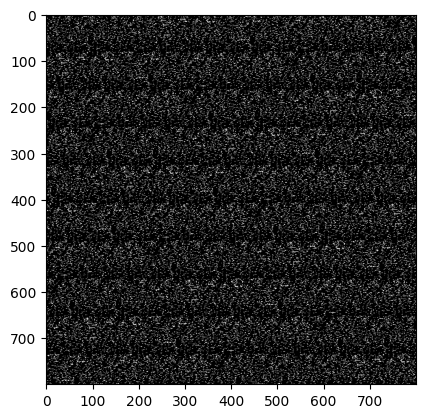

(467, 140)


In [516]:
print(y_pred.shape)

reshaped_arr = y_pred.reshape(467 , -1)
reshaped_arr_resized = np.resize(reshaped_arr, (800, 800))
plt.imshow(reshaped_arr_resized, cmap="gray")
plt.show()
print(reshaped_arr.shape)


i = 0



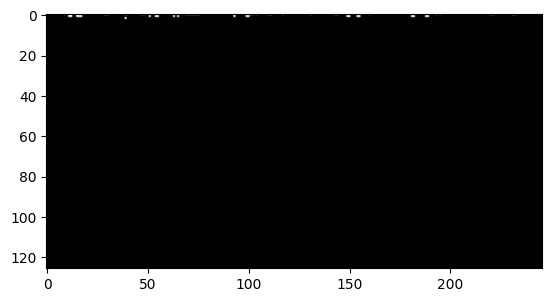

In [523]:
res = np.array(res).reshape(-1, 246)
plt.imshow(res, cmap="gray")
plt.show()

In [ ]:
res = []

for i in range(0, len(y_pred), 5):
    res.append(y_pred[i*5: (i*5) + 5])

res = np.array(res)
res.shape
plt.imshow(res, cmap="gray")